# **Lego Brick Classification Project**

**Data**: https://www.kaggle.com/datasets/ronanpickell/b200c-lego-classification-dataset

**Goal:** recognition of individual Lego pieces

**Stakeholder:** startup creator working on an application for recognizing Lego pieces based on user photographs.

---

This notebook contains my contribution to the project and the 1st version of model I created, which we tentatively named RocketNet.

Due to hardware limitations, the project was carried out on Google Colab.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Loading libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import random
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, auc, roc_curve, f1_score, r2_score, confusion_matrix, mean_squared_error
from datetime import datetime
import os

In [ ]:
!pip freeze > requirements.txt

2. Loading the database from Google Drive.

In [ ]:
base_dir = '/content/drive/MyDrive/BOOTCAMP/lego'

In [ ]:
full_dataset = image_dataset_from_directory(
    base_dir,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=123
)

Found 80028 files belonging to 20 classes.


3. Let's load and prepare the data.

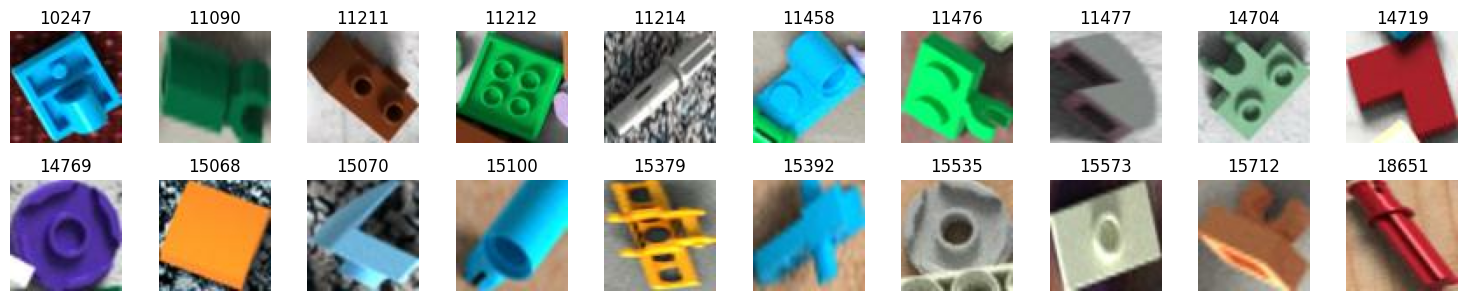

In [ ]:
class_names = full_dataset.class_names

def plot_one_image_per_class(dataset, class_names):

    images_per_class = {class_name: None for class_name in class_names}

    for images, labels in dataset:
        for img, lbl in zip(images, labels):
            class_idx = np.argmax(lbl)
            class_name = class_names[class_idx]
            if images_per_class[class_name] is None:
                images_per_class[class_name] = img.numpy().astype("uint8")
            if all(v is not None for v in images_per_class.values()):
                break
        if all(v is not None for v in images_per_class.values()):
            break

    plt.figure(figsize=(15, 15))
    for i, class_name in enumerate(class_names):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images_per_class[class_name])
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_one_image_per_class(full_dataset, class_names)

In [ ]:
# Number of images in the dataset.
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()

In [ ]:
print(dataset_size)

2501


In [ ]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.1 * dataset_size)    # 10% for validation
test_size = dataset_size - train_size - val_size  # 20% for testing

In [ ]:
# We use skip and take to split the dataset.
train_dataset = full_dataset.take(train_size)
rest_dataset = full_dataset.skip(train_size)
val_dataset = rest_dataset.take(val_size)
test_dataset = rest_dataset.skip(val_size)

In [ ]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Splitting the entire validation set into test and validation sets for the model.

In [ ]:
num_train_batches = train_dataset.cardinality().numpy()
num_test_batches = test_dataset.cardinality().numpy()
num_val_batches = val_dataset.cardinality().numpy()

print(f'Number of batches in the training set: {num_train_batches}')
print(f'Number of batches in the test set: {num_test_batches}')
print(f'Number of batches in the validation set: {num_val_batches}')

Number of batches in the training set: 1750
Number of batches in the test set: 501
Number of batches in the validation set: 250


4. Let's build the neural network model.

In [ ]:
model = Sequential()

In [ ]:
# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), name='conv_layer_1'))
model.add(BatchNormalization(name='batchnorm_layer_1'))  # Adding BatchNormalization
model.add(MaxPooling2D((2, 2), name='maxpool_layer_1'))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu', name='conv_layer_2'))
model.add(BatchNormalization(name='batchnorm_layer_2'))  # Adding BatchNormalization
model.add(MaxPooling2D((2, 2), name='maxpool_layer_2'))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu', name='conv_layer_3'))
model.add(BatchNormalization(name='batchnorm_layer_3'))  # Adding BatchNormalization
model.add(MaxPooling2D((2, 2), name='maxpool_layer_3'))

# Flatten layer
model.add(Flatten(name='flatten_layer'))

# First dense layer
model.add(Dense(512, activation='relu', name='dense_layer_1'))
model.add(Dropout(0.5, name='dropout_layer'))

# Output dense layer
model.add(Dense(len(class_names), activation='softmax', name='output_layer'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# When setting label_mode='categorical' in the image_dataset_from_directory function,
# labels are automatically encoded as one-hot vectors, so categorical_crossentropy is the appropriate loss function.

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_layer_1 (Conv2D)                │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_layer_1                    │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_layer_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2 (Conv2D)                │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_layer_2                    │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_layer_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_3 (Conv2D)                │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_layer_3                    │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_layer_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,464,212 (9.40 MB)

 Trainable params: 2,463,764 (9.40 MB)

 Non-trainable params: 448 (1.75 KB)

5. Training the model.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Definition of early stopping.
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5,
    restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 1535s 873ms/step - categorical_accuracy: 0.2537 - loss: 2.7590 - val_categorical_accuracy: 0.4905 - val_loss: 1.6764
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 148s 85ms/step - categorical_accuracy: 0.5571 - loss: 1.3613 - val_categorical_accuracy: 0.7255 - val_loss: 0.8871
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 146s 84ms/step - categorical_accuracy: 0.6806 - loss: 0.9913 - val_categorical_accuracy: 0.7933 - val_loss: 0.6863
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 147s 84ms/step - categorical_accuracy: 0.7464 - loss: 0.7925 - val_categorical_accuracy: 0.8449 - val_loss: 0.5213
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 145s 83ms/step - categorical_accuracy: 0.7916 - loss: 0.6545 - val_categorical_accuracy: 0.7984 - val_loss: 0.7836
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 147s 84ms/step - categorical_accuracy: 0.8185 - loss: 0.5676 - val_categorical_accuracy: 0.8620 - val_loss: 0.4566
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 146s 84ms/step

In [ ]:
# Evaluation on the test set.
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

501/501 ━━━━━━━━━━━━━━━━━━━━ 424s 695ms/step - categorical_accuracy: 0.9050 - loss: 0.3965
Test Loss: 0.38832125067710876
Test Accuracy: 0.9043548703193665


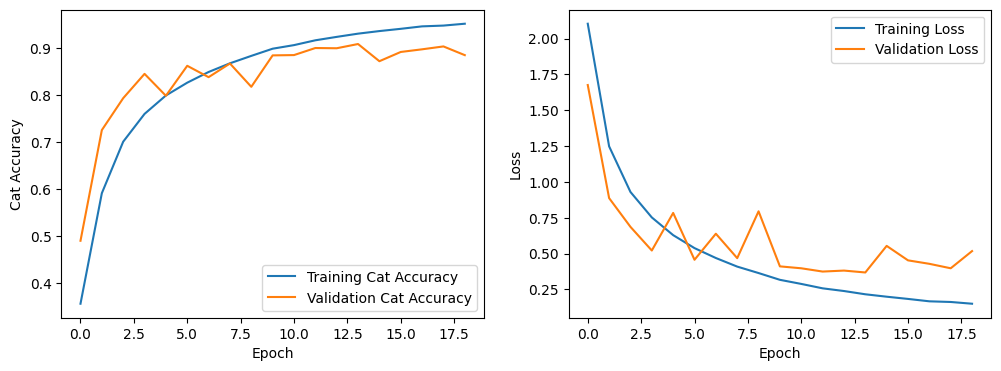

In [ ]:
# Print the training history.
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Training Cat Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Cat Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

6. Model evaluation.

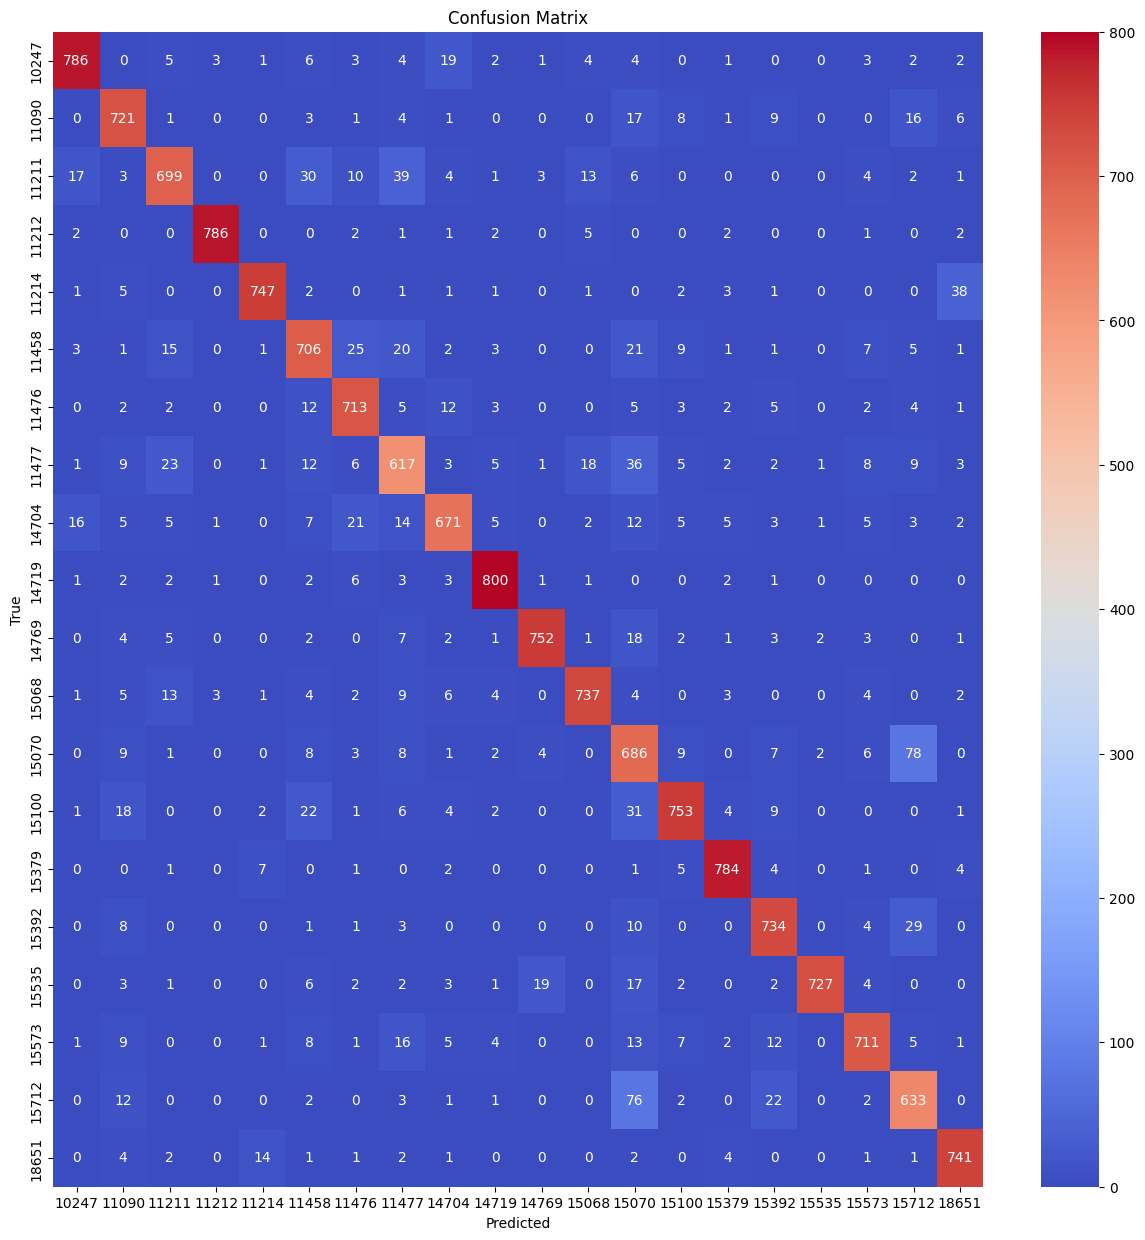

Classification Report:
              precision    recall  f1-score   support

       10247       0.95      0.93      0.94       846
       11090       0.88      0.91      0.90       788
       11211       0.90      0.84      0.87       832
       11212       0.99      0.98      0.98       804
       11214       0.96      0.93      0.95       803
       11458       0.85      0.86      0.85       821
       11476       0.89      0.92      0.91       771
       11477       0.81      0.81      0.81       762
       14704       0.90      0.86      0.88       783
       14719       0.96      0.97      0.96       825
       14769       0.96      0.94      0.95       804
       15068       0.94      0.92      0.93       798
       15070       0.72      0.83      0.77       824
       15100       0.93      0.88      0.90       854
       15379       0.96      0.97      0.96       810
       15392       0.90      0.93      0.91       790
       15535       0.99      0.92      0.96       789
    

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def get_predictions_and_labels(dataset):
    predictions = []
    labels = []
    for images, lbls in dataset:
        preds = model.predict(images, verbose=0)
        predictions.extend(np.argmax(preds, axis=1))
        labels.extend(np.argmax(lbls.numpy(), axis=1))
    return predictions, labels

predictions, true_labels = get_predictions_and_labels(test_dataset)

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)


In [ ]:
# Model evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Training historyu
history_dict = history.history

# Accuracy at the end of training
final_train_accuracy = history_dict['categorical_accuracy'][-1]
final_val_accuracy = history_dict['val_categorical_accuracy'][-1]

print(f'Final Training Accuracy: {final_train_accuracy:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

501/501 ━━━━━━━━━━━━━━━━━━━━ 98s 40ms/step - categorical_accuracy: 0.9039 - loss: 0.4035
Test Accuracy: 0.9040
Final Training Accuracy: 0.9513
Final Validation Accuracy: 0.8846
